# IMDB美国票房TOP 1000电影分析
之前利用Python的request和BeautifulSoup工具包爬取了IMDB网站上美国电影票房历史排名前1000的电影数据，本文以此数据为基础，作相关的数据分析。分析步骤大致与猴子哥live中介绍的方法一致：分为提出问题--理解数据--数据清洗--数据可视化。猴子哥live中有一步是构建模型，我把这部分融合到了数据可视化环节中。

# 1. 提出问题
本文使用的数据是IMDB美国票房排名前1000的电影数据，数据包含了电影名称，票房金额，上映年份，演职人员，IMDB评分，电影类型等信息，数据中的很多电影大家也比较熟悉。
相信不少人都有这样的经历，当想要看一部电影的时候，会去百度一下谁是导演，谁是主演。如果导演是克里斯托弗·诺兰，心里已经给电影打了个8分以上的评分了。而阿汤哥的动作片，预期也都能肾上腺素飙升。对于已上映的电影，不少人会去豆瓣搜索现时的评分，或是前作的评价，若是豆瓣高分、高评论数，也会按奈不住去蹭下热度。如果要去电影院观看的话，想必不少人会更倾向选择动作片或者科幻大片这类特效丰富，影音冲击强烈的电影。近几年特效技术和3D动画的日渐成熟，影院观影已经是越来越多人的第一选择。所以结合以上信息，可以针对IMDB电影数据提出以下问题：
1. 电影年份的分布如何？近几年特效丰富的电影（以动作片、动画片为主）是否在更加流行？
2. 电影类型的分布如何？哪类电影的平均分较高？
3. 动作片或者科幻片等特效丰富的电影比例是否更高？
4. 电影时长的分布如何？时长是否和评分有相关性？
5. IMDB评分是否和票房有相关性？
6. 哪些导演的电影更受观众喜爱？
7. 哪些演员的电影总票房更高？

# 2. 理解数据
数据分析的第二部分是理解数据，这里要先读取数据并查看数据的内容，了解数据的组成和包含的信息。根据数据的内容和类型，考虑下一步的数据清洗，例如删除重复项，填充缺失值等。

In [1]:
# 导入相关模块
import pandas as pd
import numpy as np

In [2]:
# 读取存储的csv文件
df = pd.read_csv('us_box_top1000.csv')

In [3]:
# 查看数据的行列数
df.shape

(1000, 13)

In [4]:
# 计算重复行数据
sum(df.duplicated())

0

读取的数据有1000行，13列，没有重复行。由于爬取的是美国历史票房排名前1000的电影数据，目前来看数据符合预期。

In [5]:
# 查看数据的列标题
df.columns

Index(['rank', 'title', 'year', 'certificate', 'runtime', 'genre', 'imdb_rate',
       'metascore', 'votes', 'gross', 'director', 'stars', 'intro'],
      dtype='object')

对比IMDB网页内容，列标题基本上涵盖了每部电影的完整信息。
![imdb_page](https://d2r1vs3d9006ap.cloudfront.net/s3_images/931309/Titanic_inline.jpg?1374753116)

In [6]:
# 查看更多的列信息和每列数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
rank           1000 non-null object
title          1000 non-null object
year           1000 non-null object
certificate    1000 non-null object
runtime        1000 non-null object
genre          1000 non-null object
imdb_rate      1000 non-null float64
metascore      981 non-null float64
votes          1000 non-null object
gross          1000 non-null object
director       1000 non-null object
stars          1000 non-null object
intro          1000 non-null object
dtypes: float64(2), object(11)
memory usage: 101.6+ KB


可见数据相对完整，只有一列存在19个缺失值，即`metascore`。根据谷歌的信息，可以知道imdb上的metascore来源于网站Metacritic，是根据专业媒体人士的评论生成的得分，更多信息可以参考这里：[链接](https://en.wikipedia.org/wiki/Metacritic)

In [7]:
# 查看数据的统计信息
df.describe()

,imdb_rate,metascore
count,1000.00000,981.000000
mean,6.81380,59.815494
std,0.91511,16.108991
min,3.20000,12.000000
25%,6.20000,48.000000
50%,6.90000,60.000000
75%,7.50000,72.000000
max,9.20000,100.000000


- 由于只有`imdb_rate`评分和`metascore`评分两列数据是numeric型的，所以`df.describe()`只显示这两列的统计信息。如果要显示所有列的统计信息，可以使用`df.describe(include='all')`。
- 对比10分制的imdb评分和100分制的metascore评分，可见imdb评分相对波动范围较小，最高分9.2分，最低分3.2分，而metascore评分最高分100分，最低分低至12分。之后可以使用直方图比较二者的评分分布情况。

In [8]:
# 查看前5行数据
df.head()

,rank,title,year,certificate,runtime,genre,imdb_rate,metascore,votes,gross,director,stars,intro
0,1.,Star Wars: The Force Awakens,(2015),PG-13,136 min,"\nAction, Adventure, Fantasy",8.0,81.0,"753,597",$936.66M,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","\n Three decades after the Empire's defeat,..."
1,2.,Avatar,(2009),PG-13,162 min,"\nAction, Adventure, Fantasy",7.8,83.0,"1,001,946",$760.51M,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",\n A paraplegic marine dispatched to the mo...
2,3.,Black Panther,(2018),PG-13,134 min,"\nAction, Adventure, Sci-Fi",7.4,88.0,"389,075",$700.06M,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","\n T'Challa, heir to the hidden but advance..."
3,4.,Avengers: Infinity War,(2018),PG-13,149 min,"\nAction, Adventure, Fantasy",8.6,68.0,"484,431",$678.82M,Anthony Russo,"Joe Russo, Robert Downey Jr., Chris Hemsworth,...",\n The Avengers and their allies must be wi...
4,5.,Titanic,(1997),PG-13,194 min,"\nDrama, Romance",7.8,75.0,"909,482",$659.33M,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",\n A seventeen-year-old aristocrat falls in...


- 前5行数据对应美国票房最高的5部电影，首位的是《星球大战：原力觉醒》，第二位是《阿凡达》，第三名出人意料地被今年上映的漫威电影《黑豹》拿下，力压排在第四位的漫威同门大作《复仇者联盟：无限战争》，第五名是家喻户晓的经典爱情电影《泰坦尼克号》。
- 根据显示的信息，可以知道13列数据对应的数据信息。分别是rank: 票房排名，title: 电影名，year: 上映年份，certificate: 电影分级，runtime: 电影时长，genre: 电影类型，imdb_rate: imdb评分，metascore: metascore评分，votes: 投票人数，gross: 票房，director: 导演，stars: 主演明星，intro: 简介。
- 部分数据列需要清洗并转换数据类型。`rank`列的数据是排名数据，都应该是整数，清洗时需要删掉整数后面多余的点号”.“并转换成`int`类型。`year`年份，`runtime`电影时长（分钟数）和`votes`投票人数也应该转换成整数。`gross`票房数据带美金符号和字母`M`，含两位小数，清洗后需要转换成`float`类型。`genre`电影类型和`intro`简介两列数据开头含有冗余的`\n`，需要删除。
- `genre`电影类型和`stars`主演明星含有多个值，`director`导演数据可能也存在有两个或以上导演名的情况，后面需要考虑做适当处理。

# 3. 数据清洗
根据上述分析，按照列标题顺序对数据进行清洗，每一步都使用`df[col_name].head()`或者其他合适的方法检查清洗后的数据。

In [9]:
# 清洗rank列，删除多余的”.“号并转换成int类型
df['rank'] = df['rank'].str.replace('.', '').astype(int)

ValueError: invalid literal for int() with base 10: '1,000'

此时报错：`ValueError: invalid literal for int() with base 10: '1,000'`，原因是`1,000`中含有千位符，无法转换成`int`类型，需要把千位符删除。修改代码如下：

In [10]:
# 使用两次str.replace()
df['rank'] = df['rank'].str.replace('.', '').str.replace(',', '').astype(int)
df['rank'].head()

0    1
1    2
2    3
3    4
4    5
Name: rank, dtype: int64

In [11]:
# 检查year列数据的唯一值
df['year'].unique()

array(['(2015)', '(2009)', '(2018)', '(1997)', '(2012)', '(2017)',
       '(2008)', '(2016)', '(1999)', '(2004)', '(1982)', '(2013)',
       '(2006)', '(2010)', '(2002)', '(1993)', '(I) (2013)', '(2011)',
       '(2003)', '(2005)', '(I) (2015)', '(2014)', '(2007)', '(I) (2010)',
       '(1994)', '(I) (2017)', '(1977)', '(2001)', '(1983)', '(1996)',
       '(1980)', '(1990)', '(2000)', '(1975)', '(1989)', '(I) (2016)',
       '(1981)', '(1984)', '(1973)', '(1991)', '(1992)', '(1998)',
       '(1985)', '(1939)', '(1995)', '(I) (2008)', '(1978)', '(1937)',
       '(1986)', '(I) (2005)', '(II) (2015)', '(I) (1995)', '(1988)',
       '(I) (2011)', '(1987)', '(I) (2009)', '(1965)', '(I) (2014)',
       '(1961)', '(1967)', '(IX) (2016)', '(I) (1998)', '(1972)',
       '(I) (2012)', '(1974)', '(1976)', '(1970)', '(1979)', '(1942)',
       '(1969)', '(1964)', '(II) (2016)', '(1971)', '(1956)', '(1955)',
       '(1953)', '(III) (2015)', '(1950)', '(1940)', '(I) (1999)'],
      dtype=object)

年份数据很乱，不少年份信息前面还含有冗余字符，例如(III)等。通过观察可发现，年份的四位数字出现在倒数第五个字符至倒数第二个字符，可以通过`str[:]`方法选取这四位字符再转换成`int`类型。此外，榜单中有不少电影年代久远，考虑到数据可比性，只保留1980年以后的电影。

In [12]:
# 清洗year列，使用str[:]选取年份数字并转换成int类型，使用df.unique()方法检查数据
df['year'] = df['year'].str[-5:-1].astype(int)
df['year'].unique()

array([2015, 2009, 2018, 1997, 2012, 2017, 2008, 2016, 1999, 2004, 1982,
       2013, 2006, 2010, 2002, 1993, 2011, 2003, 2005, 2014, 2007, 1994,
       1977, 2001, 1983, 1996, 1980, 1990, 2000, 1975, 1989, 1981, 1984,
       1973, 1991, 1992, 1998, 1985, 1939, 1995, 1978, 1937, 1986, 1988,
       1987, 1965, 1961, 1967, 1972, 1974, 1976, 1970, 1979, 1942, 1969,
       1964, 1971, 1956, 1955, 1953, 1950, 1940])

In [13]:
# 保留1980年以后的电影
df = df[df['year'] >= 1980]

In [14]:
# 检查certificate列，查看数据分布
df['certificate'].value_counts()

PG-13    429
PG       239
R        233
G         46
Name: certificate, dtype: int64

结合[维基百科--美国电影分级制度](https://zh.wikipedia.org/wiki/美国电影分级制度)可知，PG-13, PG, R, G都是现有的电影分级符号。

In [15]:
# 清洗runtime电影时长列数据，可使用str.split()方法
df['runtime'] = df['runtime'].str.split(' ').str.get(0).astype(int)
df['runtime'].head()

0    136
1    162
2    134
3    149
4    194
Name: runtime, dtype: int64

In [16]:
# 清洗genre电影类型数据，去掉前面的'\n'和可能存在的空格
df['genre'] = df['genre'].str.replace('\n', '').str.strip()
df['genre'].head()

0    Action, Adventure, Fantasy
1    Action, Adventure, Fantasy
2     Action, Adventure, Sci-Fi
3    Action, Adventure, Fantasy
4                Drama, Romance
Name: genre, dtype: object

每个的电影类型数据含有多个值，这里可以通过分析电影内容来判断电影类型，选取一个值作为电影的主题。先查看票房前20的电影信息。

In [17]:
df.head(20)

,rank,title,year,certificate,runtime,genre,imdb_rate,metascore,votes,gross,director,stars,intro
0,1,Star Wars: The Force Awakens,2015,PG-13,136,"Action, Adventure, Fantasy",8.0,81.0,"753,597",$936.66M,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","\n Three decades after the Empire's defeat,..."
1,2,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83.0,"1,001,946",$760.51M,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",\n A paraplegic marine dispatched to the mo...
2,3,Black Panther,2018,PG-13,134,"Action, Adventure, Sci-Fi",7.4,88.0,"389,075",$700.06M,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","\n T'Challa, heir to the hidden but advance..."
3,4,Avengers: Infinity War,2018,PG-13,149,"Action, Adventure, Fantasy",8.6,68.0,"484,431",$678.82M,Anthony Russo,"Joe Russo, Robert Downey Jr., Chris Hemsworth,...",\n The Avengers and their allies must be wi...
4,5,Titanic,1997,PG-13,194,"Drama, Romance",7.8,75.0,"909,482",$659.33M,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",\n A seventeen-year-old aristocrat falls in...
5,6,Jurassic World,2015,PG-13,124,"Action, Adventure, Sci-Fi",7.0,59.0,"513,632",$652.27M,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","\n A new theme park, built on the original ..."
6,7,The Avengers,2012,PG-13,143,"Action, Adventure, Sci-Fi",8.1,69.0,"1,124,875",$623.36M,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",\n Earth's mightiest heroes must come toget...
7,8,Star Wars: Episode VIII - The Last Jedi,2017,PG-13,152,"Action, Adventure, Fantasy",7.2,85.0,"414,441",$620.18M,Rian Johnson,"Daisy Ridley, John Boyega, Mark Hamill, Carrie...",\n Rey develops her newly discovered abilit...
8,9,Incredibles 2,2018,PG,118,"Animation, Action, Adventure",8.1,80.0,"98,201",$605.66M,Brad Bird,"Craig T. Nelson, Holly Hunter, Sarah Vowell, H...",\n Bob Parr (Mr. Incredible) is left to car...
9,10,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,84.0,"1,965,612",$534.86M,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",\n When the menace known as the Joker emerg...


根据前20行电影数据，`genre`列的数据中，每部电影都有两个或三个电影类型，第一个电影类型最符合电影的内容。所以选取第一个电影类型作为电影的首要类型。

In [18]:
df['main_genre'] = df['genre'].str.split(', ').str.get(0)
df['main_genre'].head()

0    Action
1    Action
2    Action
3    Action
4     Drama
Name: main_genre, dtype: object

In [19]:
# 清洗votes投票人数数据，去掉千分位符号并转换成int类型
df['votes'] = df['votes'].str.replace(',', '').astype(int)
df['votes'].head()

0     753597
1    1001946
2     389075
3     484431
4     909482
Name: votes, dtype: int64

In [20]:
# 清洗gross票房金额数据，删除美金符号$和结尾的M，并转换成float类型
df['gross'] = df['gross'].str.replace('$', '').str.replace('M', '').astype(float)
df['gross'].head()

0    936.66
1    760.51
2    700.06
3    678.82
4    659.33
Name: gross, dtype: float64

In [21]:
# 清洗intro电影简介列，删除前面的'\n'和可能存在的字符串两侧的空格
df['intro'] = df['intro'].str.replace('\n', '').str.strip()
df['intro'].head()

0    Three decades after the Empire's defeat, a new...
1    A paraplegic marine dispatched to the moon Pan...
2    T'Challa, heir to the hidden but advanced king...
3    The Avengers and their allies must be willing ...
4    A seventeen-year-old aristocrat falls in love ...
Name: intro, dtype: object

初步的清洗工作完毕，使用`df.info()`和`df.head()`确认数据清洗后的效果。

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 14 columns):
rank           947 non-null int64
title          947 non-null object
year           947 non-null int64
certificate    947 non-null object
runtime        947 non-null int64
genre          947 non-null object
imdb_rate      947 non-null float64
metascore      940 non-null float64
votes          947 non-null int64
gross          947 non-null float64
director       947 non-null object
stars          947 non-null object
intro          947 non-null object
main_genre     947 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 111.0+ KB


In [23]:
df.head()

,rank,title,year,certificate,runtime,genre,imdb_rate,metascore,votes,gross,director,stars,intro,main_genre
0,1,Star Wars: The Force Awakens,2015,PG-13,136,"Action, Adventure, Fantasy",8.0,81.0,753597,936.66,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Three decades after the Empire's defeat, a new...",Action
1,2,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83.0,1001946,760.51,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",A paraplegic marine dispatched to the moon Pan...,Action
2,3,Black Panther,2018,PG-13,134,"Action, Adventure, Sci-Fi",7.4,88.0,389075,700.06,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","T'Challa, heir to the hidden but advanced king...",Action
3,4,Avengers: Infinity War,2018,PG-13,149,"Action, Adventure, Fantasy",8.6,68.0,484431,678.82,Anthony Russo,"Joe Russo, Robert Downey Jr., Chris Hemsworth,...",The Avengers and their allies must be willing ...,Action
4,5,Titanic,1997,PG-13,194,"Drama, Romance",7.8,75.0,909482,659.33,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",A seventeen-year-old aristocrat falls in love ...,Drama


清洗后的数据看起来不错！由于在数据清洗中，去掉了部分列数中包含的数据单位信息，例如电影时长的单位'min'，因此可以通过修改列标题将单位信息添加到列标题上，方便读者理解数据。

In [24]:
# 重命名部分列标题
df.rename(columns={'runtime': 'runtime_min', 'gross': 'gross_million_dollar'}, inplace=True)
df.columns

Index(['rank', 'title', 'year', 'certificate', 'runtime_min', 'genre',
       'imdb_rate', 'metascore', 'votes', 'gross_million_dollar', 'director',
       'stars', 'intro', 'main_genre'],
      dtype='object')

由于`df['metascore']`列存在部分缺失值，首先查看缺失值的行数据再决定处理方法。

In [25]:
# 查看缺失值所在的行
condition = df['metascore'].isnull()
df[condition]

,rank,title,year,certificate,runtime_min,genre,imdb_rate,metascore,votes,gross_million_dollar,director,stars,intro,main_genre
264,265,Home Alone 2: Lost in New York,1992,PG,120,"Adventure, Comedy, Family",6.7,NaN,245973,173.59,Chris Columbus,"Macaulay Culkin, Joe Pesci, Daniel Stern, Cath...",One year after Kevin was left home alone and h...,Adventure
645,646,Dick Tracy,1990,PG,105,"Action, Comedy, Crime",6.1,NaN,52159,103.74,Warren Beatty,"Warren Beatty, Madonna, Al Pacino, Charlie Korsmo",The comic strip detective finds his life vastl...,Action
695,696,The Rugrats Movie,1998,G,79,"Animation, Adventure, Comedy",5.9,NaN,16052,100.49,Igor Kovalyov,"Norton Virgien, Elizabeth Daily, Christine Cav...","Tommy, Chuckie, Phil, Lil and newborn baby Dil...",Animation
710,711,The Hunchback of Notre Dame,1996,G,91,"Animation, Drama, Family",6.9,NaN,120941,100.14,Gary Trousdale,"Kirk Wise, Demi Moore, Jason Alexander, Mary K...",A deformed bell-ringer must assert his indepen...,Animation
820,821,The Hand That Rocks the Cradle,1992,R,110,"Drama, Thriller",6.6,NaN,33624,88.04,Curtis Hanson,"Annabella Sciorra, Rebecca De Mornay, Matt McC...","After her humiliated husband kills himself, an...",Drama
826,827,Out of Africa,1985,PG,161,"Biography, Drama, Romance",7.2,NaN,61658,87.10,Sydney Pollack,"Meryl Streep, Robert Redford, Klaus Maria Bran...","In 20th-century colonial Kenya, a Danish baron...",Biography
997,998,The Jewel of the Nile,1985,PG,106,"Action, Adventure, Comedy",6.1,NaN,44713,75.97,Lewis Teague,"Michael Douglas, Kathleen Turner, Danny DeVito...",When Joan Wilder is abducted while on a trip a...,Action


这些电影大部分是票房相对低的电影，所以舍弃这部分的电影。

In [26]:
# 只保留含有metascore得分的电影
df = df[df['metascore'].notnull()]

# 4. 数据可视化
根据第一部分提出的问题，探索数据并进行数据可视化。数据建模部分包含在这个模块。

## 4.1 电影年份的分布

### 4.1.1 电影数量在不同年份的分布

In [27]:
# 导入并设置数据可视化相关模块
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(color_codes=True)
sns.set_style('white')
sns.set_palette('tab20')

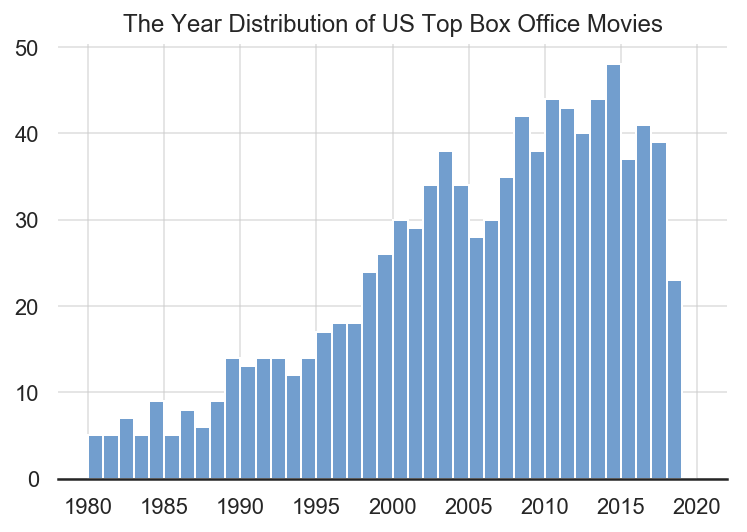

In [28]:
# 根据电影年份数据作直方图
fig, ax = plt.subplots()
df['year'].hist(range=(1980,2020), bins=40, color=(114/255,158/255,206/255))
ax.set_title('The Year Distribution of US Top Box Office Movies')

# 只保留底部坐标轴
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设定xy轴标签和网格，方便阅读数据
ax.set_yticklabels([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(np.arange(1975, 2025, 5))
ax.grid(alpha=0.5)

数据显示总体上每年的高票房电影呈现逐渐增多的趋势，以每个9到10年为范围，则呈现阶梯上升的趋势。1998年起至2003年，高票房电影数量快速增加，此后基本保持在每年30部以上高票房电影的水平（不考虑不是完整年份的2018年）。

In [29]:
before = df[df['year'] < 1998]['main_genre'].value_counts(normalize=True)

after = df[df['year'] >= 1998]['main_genre'].value_counts(normalize=True)

In [30]:
century_dist = pd.concat([before, after], axis=1, sort=True)
century_dist.columns = ['before_1998', 'after_1998']
century_dist.sort_values(by='before_1998', ascending=False, inplace=True)

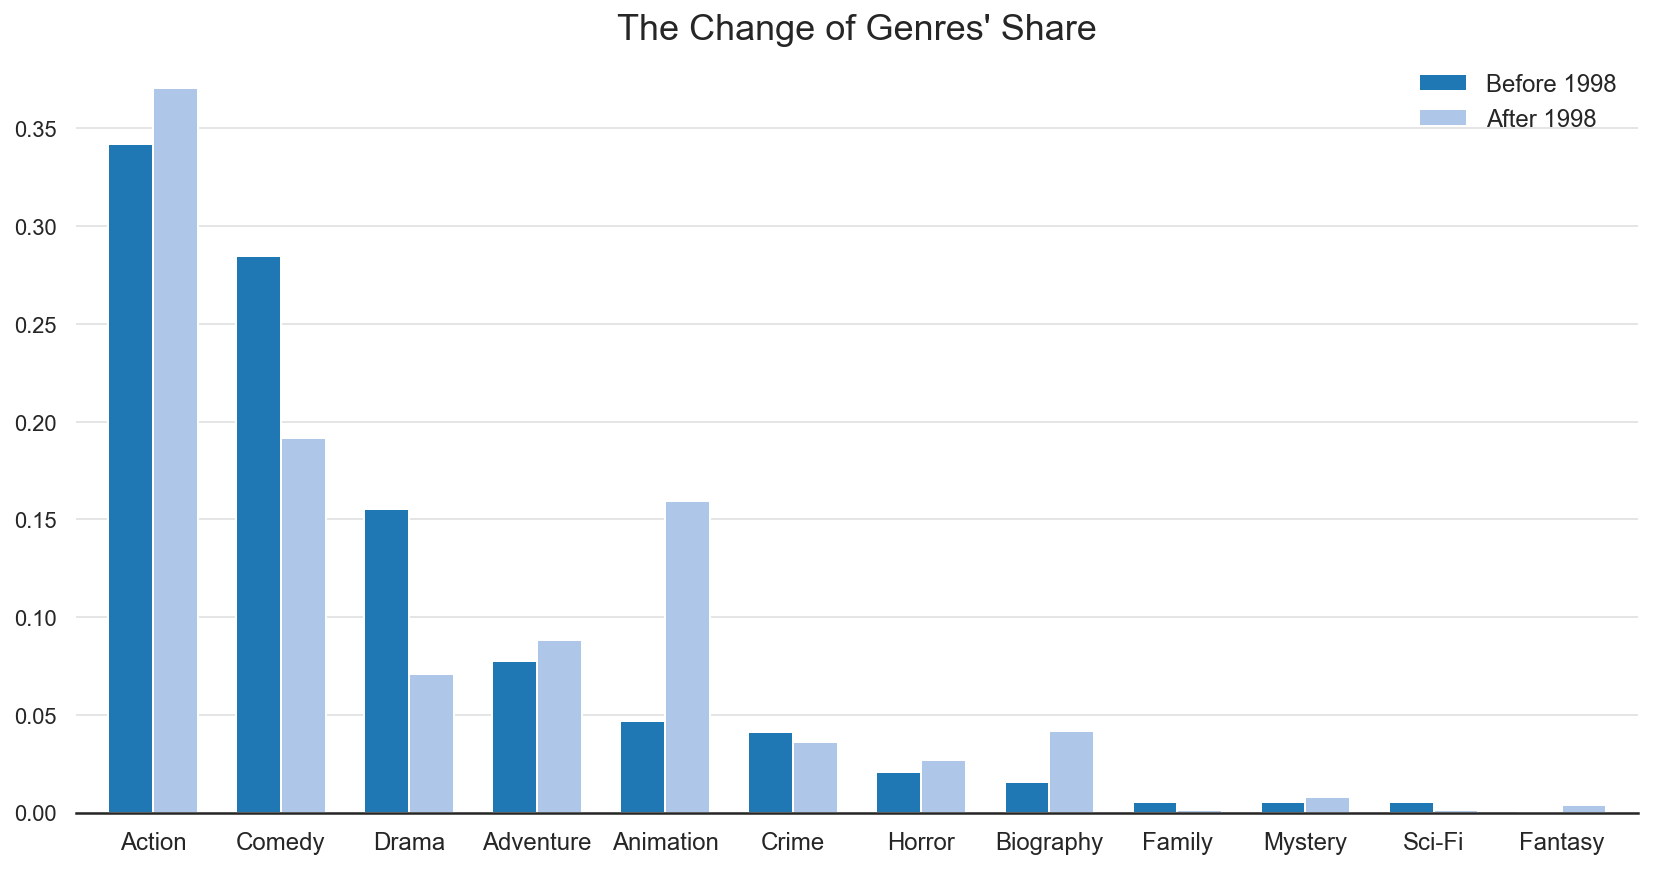

In [31]:
fig, ax1 = plt.subplots(figsize=(14,7))
century_dist.plot(kind='bar', width=0.7, ax=ax1)

ax1.set_title('The Change of Genres\' Share', fontsize=18)
ax1.set_xticklabels(century_dist.index, rotation=0, fontsize=12)
ax1.legend(['Before 1998', 'After 1998'], framealpha=0, edgecolor='white', fontsize=12)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.5)

### 4.1.2 不同电影类型的年份累计分析

In [32]:
# 统计不同年份、不同类型电影的数量
cumsum = df.groupby(['main_genre', 'year']).title.count()

# 使用累加功能统计1980年起不同年份不同电影类型的累计数量，对于中间出现的缺失值，使用前值填充
genre_cumsum = cumsum.unstack(level=0).cumsum().ffill()

# 只选取总数量大于50的电影类型数据
genre_cumsum = genre_cumsum.loc[:,genre_cumsum.iloc[-1,:] >= 50]

In [43]:
genre_cumsum

main_genre,Action,Adventure,Animation,Comedy,Drama
year,,,,,
1980,2.0,NaN,NaN,3.0,NaN
1981,3.0,NaN,NaN,6.0,1.0
1982,5.0,NaN,NaN,7.0,3.0
1983,6.0,NaN,NaN,9.0,4.0
1984,12.0,NaN,NaN,11.0,5.0
1985,13.0,1.0,NaN,12.0,7.0
1986,17.0,3.0,NaN,13.0,8.0
1987,18.0,3.0,NaN,15.0,9.0
1988,20.0,3.0,1.0,20.0,10.0


In [44]:
# 获取2018年数据作为数据标签值
last_row = genre_cumsum.iloc[-1,:]
last_row

main_genre
Action       343.0
Adventure     81.0
Animation    128.0
Comedy       198.0
Drama         83.0
Name: 2018, dtype: float64

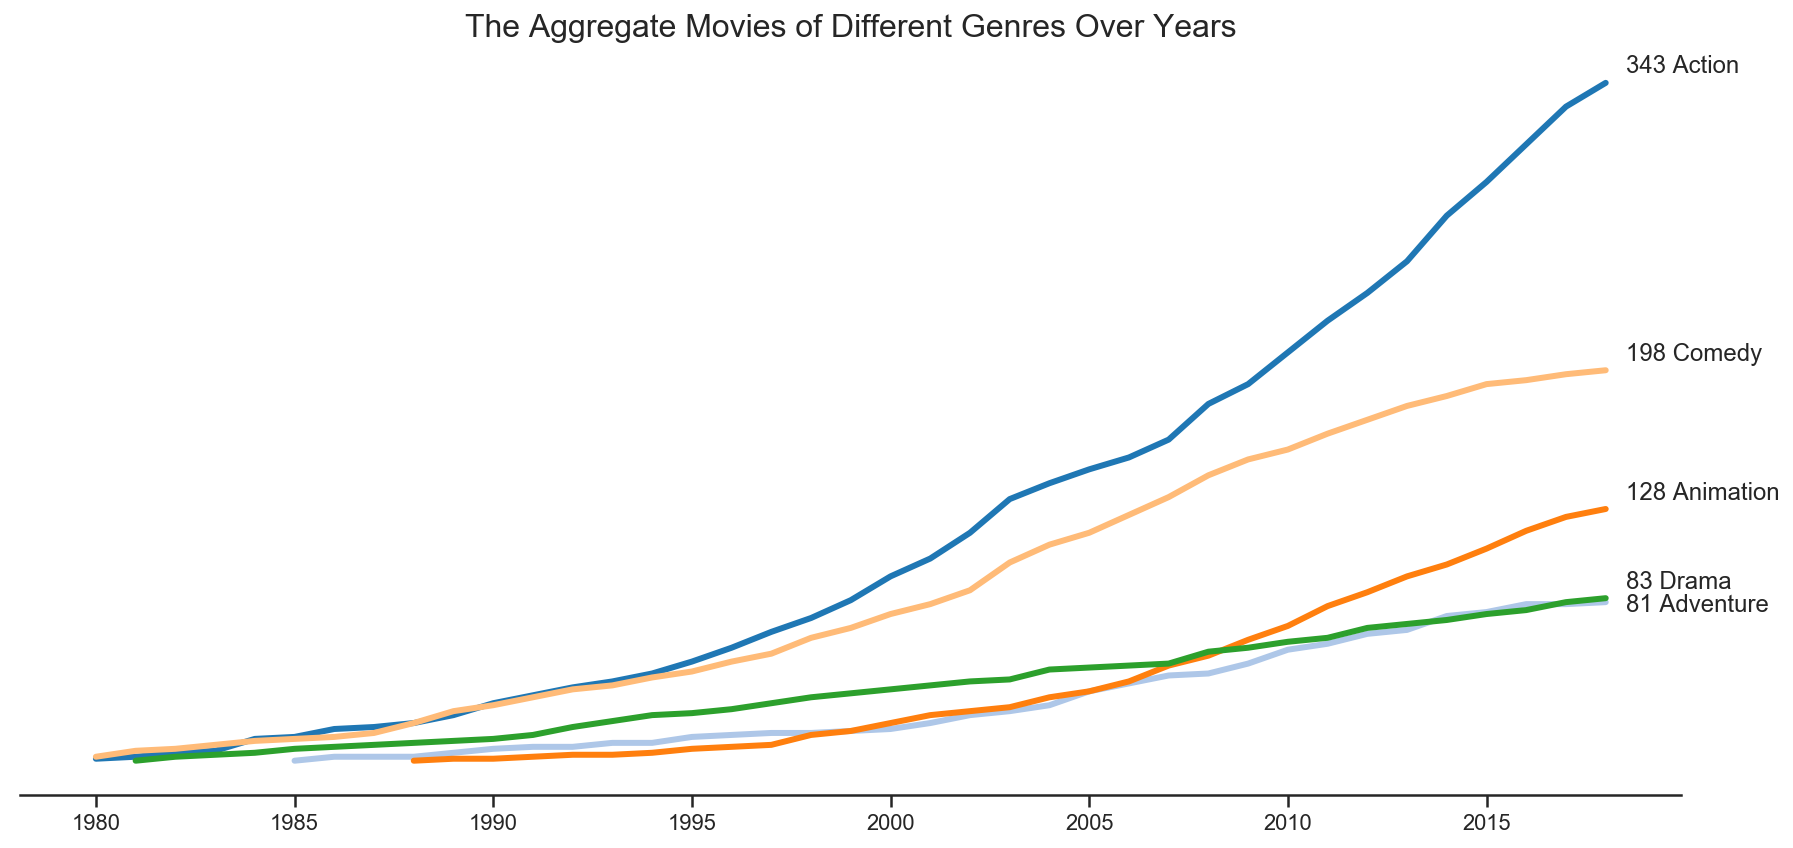

In [45]:
# 根据电影类型统计数据作图
fig, ax2 = plt.subplots(figsize=(12,6))
genre_cumsum.plot(ax=ax2, legend=False, linewidth=3)

# 添加数据标签
for i in last_row.iteritems():
    if i[0] == 'Adventure' or i[0] == 'Biography' or i[0] == 'Horror':
        ax2.annotate('{} {}'.format(int(i[1]), i[0]), xy=(2018.5, i[1]-5), fontsize=12)
    else:
        ax2.annotate('{} {}'.format(int(i[1]), i[0]), xy=(2018.5, i[1]+5), fontsize=12)

# 美化图表
ax2.set_title('The Aggregate Movies of Different Genres Over Years', fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(bottom=True, labelleft=False)
ax2.set_xlabel('')
plt.tight_layout()

从上图可见，前五大电影类型分别是动作片`Action`，喜剧片`Comedy`，动画片`Animation`，剧情片`Drama`，冒险片`Adventure`。1995年之前，动作片和喜剧片都是影院观众最喜爱的电影类型，对应的高票房数量不分伯仲，剧情片是另一相对流行的电影类型。1995年后，高票房的动作片快速增长，甩开了喜剧片。喜剧片随仍是高票房数量第二多的电影类型，但近几年增速明显放缓。高票房动画片进入榜单的时间最晚，但在1998年前后迎来明显增长，此后的十年里完成了对剧情片和冒险片的超越。如果动画片保持目前的增速，有望在之后的十几二十年里超越喜剧片，成为高票房数量第二的电影类型。

据以上不同电影类型的高票房电影数量的变化数据，可以判断最近20年来特效技术、3D及动画技术的发展和不断完善，助推了动作片、动画片的票房，因为这两类电影是这些新技术的最大受益者。

## 4.2 电影类型的分布如何？哪类电影的平均分较高？

In [36]:
# 获得电影类型的分布和平均得分数据
genre_data = df.groupby('main_genre')['title', 'imdb_rate'].agg({'title': 'count', 'imdb_rate': 'mean'}).sort_values(by='title', ascending=False)
genre_data

,title,imdb_rate
main_genre,,
Action,343,6.773761
Comedy,198,6.385859
Animation,128,6.882813
Drama,83,7.145783
Adventure,81,6.688889
Crime,35,7.431429
Biography,34,7.555882
Horror,24,6.545833
Mystery,7,7.000000


Text(11.9,6.78309,'6.8')

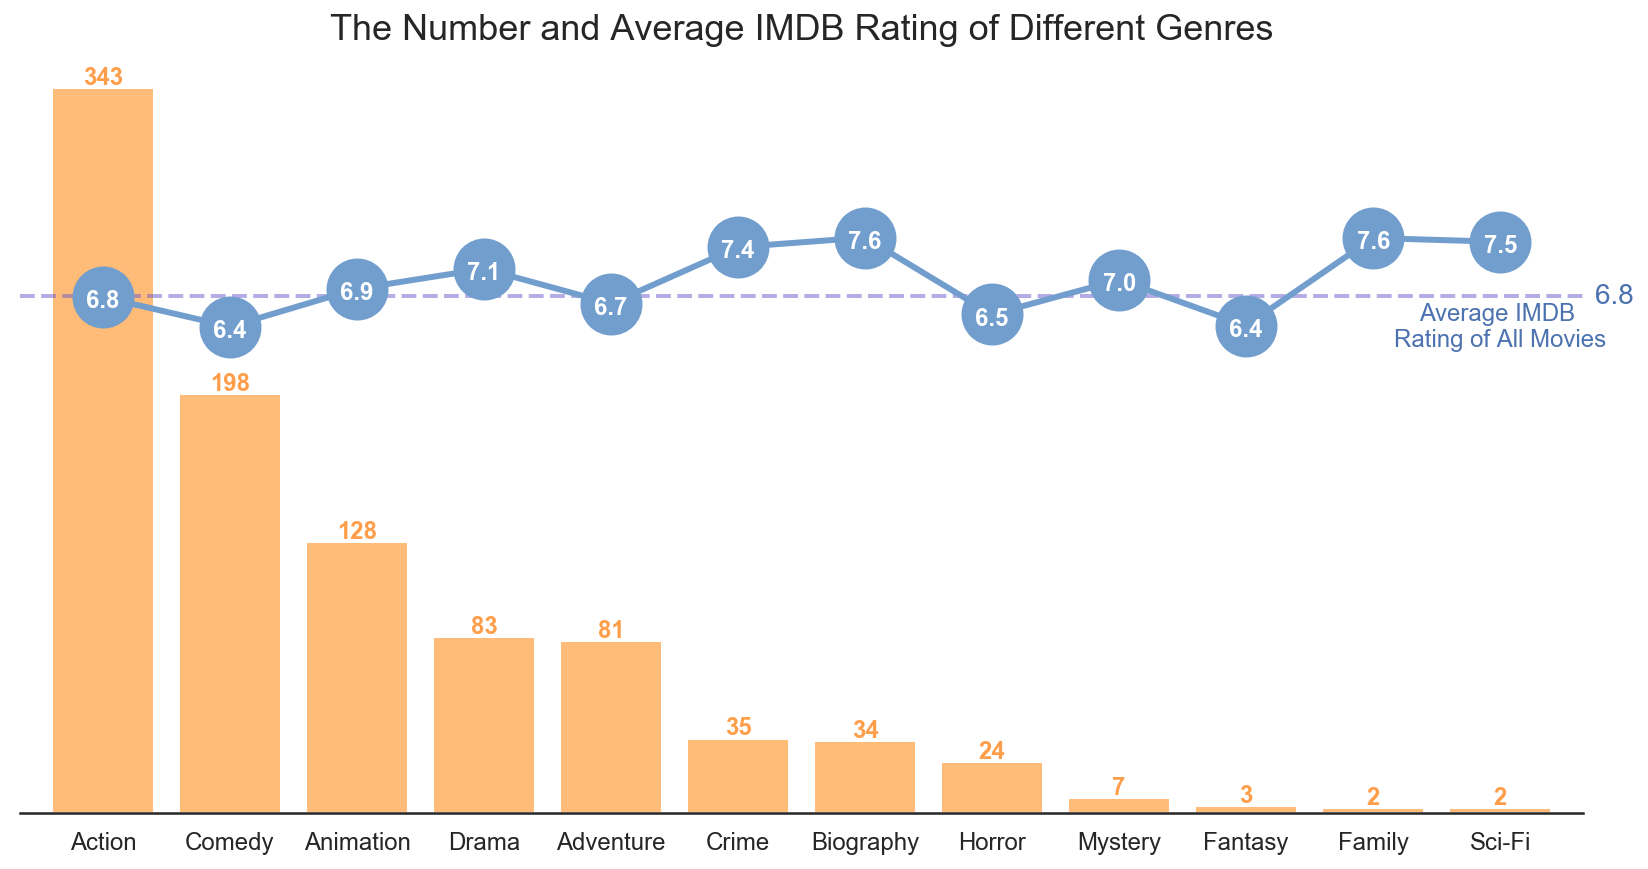

In [37]:
# 根据main_genre列数据作图
# 绘制不同电影类型的数量分布
fig, ax2 = plt.subplots(figsize=(14,7))
plt.title('The Number and Average IMDB Rating of Different Genres', fontsize=18)

genre_data['title'].plot(kind='bar', width=0.8, color=(255/255,187/255,120/255))

# 设置坐标轴格式
ax2.set_xlabel('')
ax2.set_xticklabels(genre_data.index, rotation=0, fontsize=12)
ax2.tick_params(axis='x', rotation=0)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(bottom=False, left=False, right=False, labelleft=False, color='white')

# 标记不同电影类型的数量数据
x2 = np.arange(df['main_genre'].nunique())
y2 = df['main_genre'].value_counts().values
for x,y in zip(x2, y2):
    ax2.annotate(y, xy=(x,y+5), color=(255/255,158/255,74/255), fontsize=12, weight='bold', ha='center', va='center')

# 绘制不同电影的平均IMDB分数
ax3 = ax2.twinx()
ax3.axhline(df['imdb_rate'].mean(), color='slateblue', linestyle='--', linewidth=2, alpha=0.5)

genre_data['imdb_rate'].plot(color=(114/255,158/255,206/255), marker='o', markersize=30, linewidth=3)

# 设置坐标轴格式
ax3.set_ylim(0, 10)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.tick_params(bottom=False, left=False, right=False, labelright=False, labelbottom=False)

# 标记IMDB评分数据
x3 = np.arange(df['main_genre'].nunique())
y3 = genre_data['imdb_rate'].values
for x,y in zip(x3, y3):
    ax3.annotate(round(y,1), xy=(x,y-0.05), color='white', fontsize=12, weight='bold', ha='center', va='center')

# 绘制所有IMDB电影平均得分参考线
ax3.annotate('Average IMDB \nRating of All Movies', xy=(11, df['imdb_rate'].mean()-0.4), color='b', fontsize=12, ha='center', va='center')
ax3.text(12-0.1, df['imdb_rate'].mean(), round(df['imdb_rate'].mean(),1), color='b', fontsize=14, ha='center', va='center')

进入榜单的电影类型总共有12种，除了之前已经讨论过的前5大电影类型，按数量由多到少分别是犯罪片`Crime`，传记片`Biography`，恐怖片`Horror`，悬疑片`Mystery`，奇幻片`Fantasy`，家庭片`Family`和科幻片`Sci-Fi`。犯罪片、传记片和恐怖片合计占据了1/10的比例，悬疑片，奇幻片、家庭片和科幻片合计只有14部，比例非常小。

榜单电影的IMDB平均分为6.8分。一大特征是上榜数量多的电影类型，得分反而相对低。动作片平均分刚刚达到平均线，数量排第二的喜剧片在平均得分上垫底，动画片和冒险片则接近平均线。得分高的是数量相对少的剧情片，犯罪片和传记片，都超过了7分。相对于靠特效、打斗、场面支撑的动作片、冒险片，这三类影片均是靠剧情和故事内容吸引观众的。所以好的故事还是感动观众的最重要因素。

## 4.3 电影时长的分布如何？时长是否和评分有相关性？

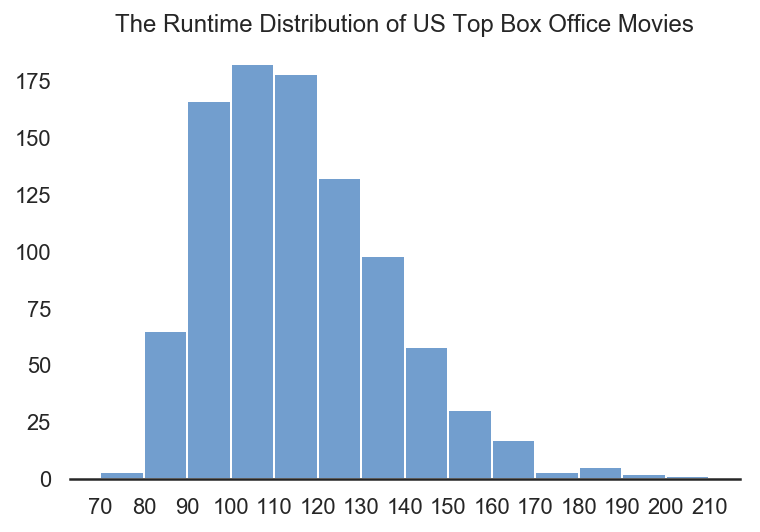

In [38]:
fig, ax4 = plt.subplots()
df['runtime_min'].hist(range=(70,210), bins=14, color=(114/255,158/255,206/255))
ax4.set_title('The Runtime Distribution of US Top Box Office Movies')

ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax4.set_xticklabels(np.arange(70,220,10))
ax4.set_xticks(np.arange(70,220,10))
ax4.grid()

这些高票房电影时长主要分布在90分钟到140分钟区间，这也是目前相对流行的影院电影时长。

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1008x504 with 0 Axes>

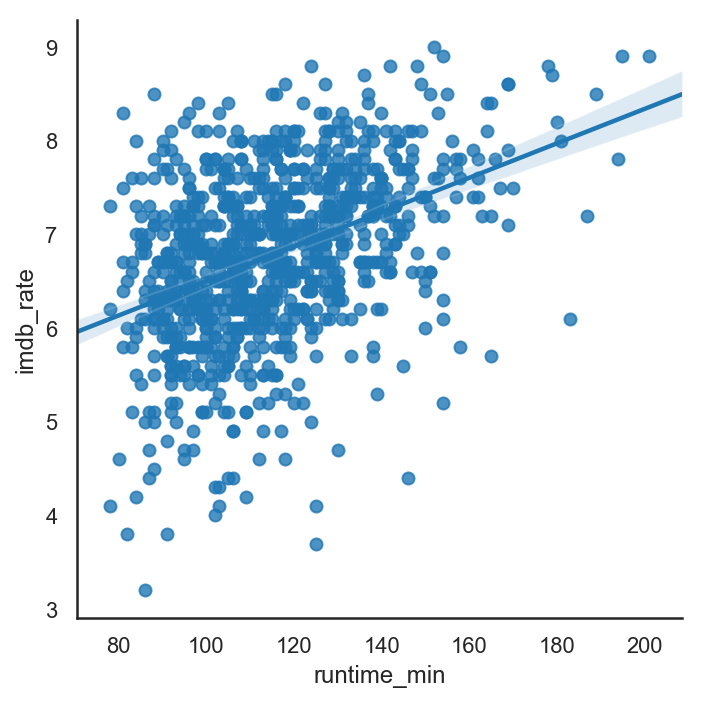

In [39]:
# 绘制时长和IMDB评分相关性
fig = plt.figure(figsize=(14,7))
sns.lmplot(data=df, x='runtime_min', y='imdb_rate')
sns.despine()

时长和IMDB评分呈一定的相关性，时长短的电影既有高分也有低分，但时长超过160分钟的电影基本都能获得6分以上的分数，时长最长的两部电影甚至得到了接近9分的超高得分，IMDB评分接近或低于4分的电影时长均小于130分钟。丰富的剧情和较长的电影篇幅可以有更多的机会去感染观众，这也和之前提到的好的故事打动观众相呼应。

## 4.4 IMDB评分和metascore评分的分布及相关性

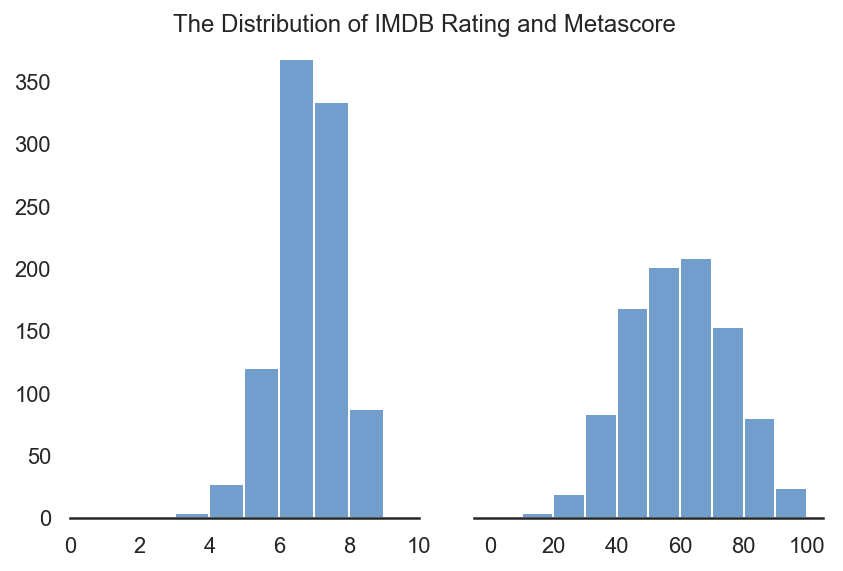

In [40]:
# 比较IMDB得分和metascore得分的分布
fig = plt.figure()
fig.suptitle('The Distribution of IMDB Rating and Metascore')

ax5 = fig.add_subplot(1,2,1)
df['imdb_rate'].hist(range=(0,10), bins=10, color=(114/255,158/255,206/255))

ax5.grid()
ax5.set_xlim(0,10)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)

ax6 = fig.add_subplot(1,2,2, sharey=ax5)
df['metascore'].hist(range=(0,100), bins=10, color=(114/255,158/255,206/255))

ax6.grid()
ax6.set_xticks([0,20,40,60,80,100])
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.tick_params(bottom=False, left=False, right=False, labelright=False, labelleft=False)

plt.tight_layout()

IMDB评分集中在6分到8分区间，9分以上的超高分电影几乎绝迹。Metascore得分的分布接近正态分布，超低分和超高分的电影都占据一定比例。

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


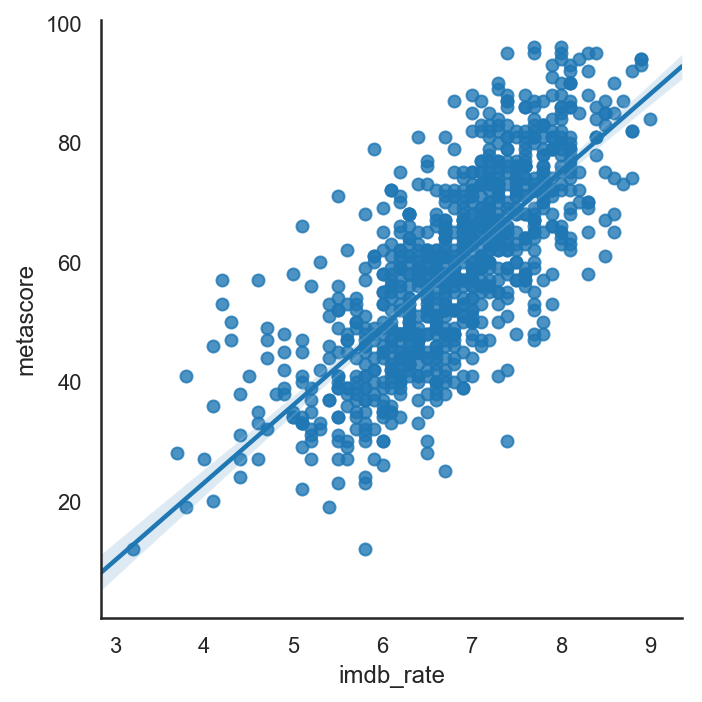

In [41]:
# IMDB评分和metascore得分的相关性
sns.lmplot(data=df, x='imdb_rate', y='metascore')
sns.despine()

可见，IMDB评分和metascore评分呈高度相关性，大众和专业影评人的评价还是相对接近的。

## 4.5 评分人数和电影票房的相关性

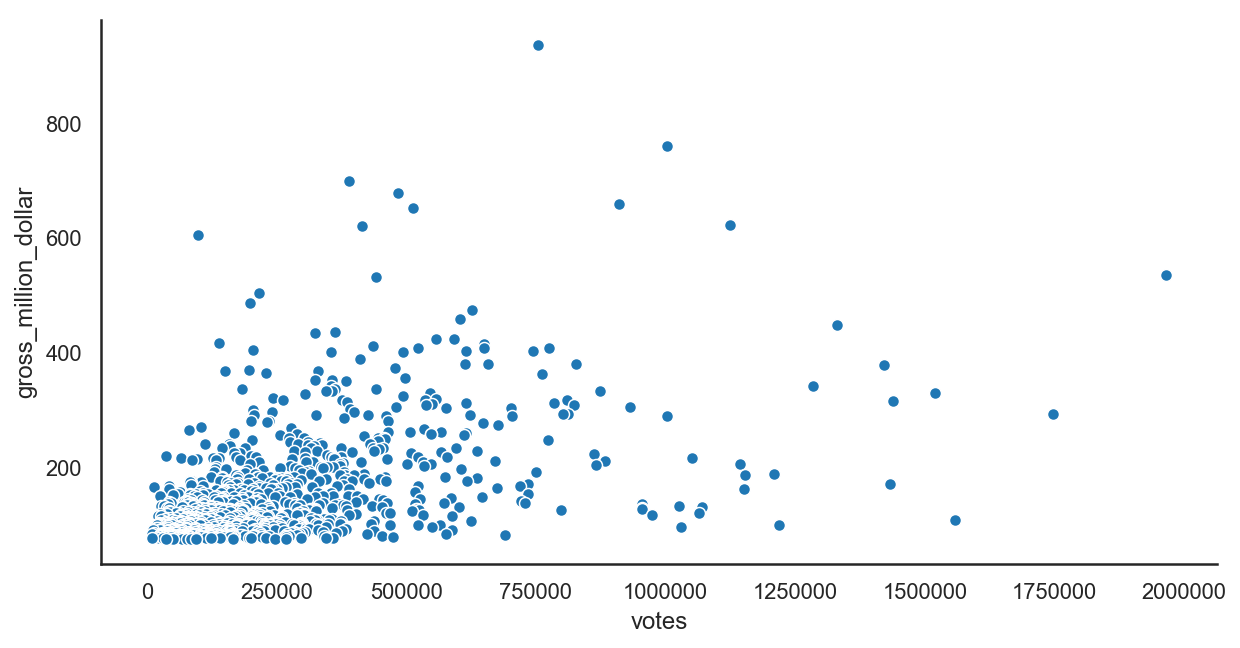

In [42]:
# IMDB评分人数和电影票房的相关性
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='votes', y='gross_million_dollar')
sns.despine()

由上图可知，IMDB评分人数和电影票房的相关性很弱，高票房不代表评分人数多，低票房电影也能有大量的IMDB评分人数。